# Evaluation des la position géographique des devices

Le but de ce challenge est l'estimation de la position géographique de devices connectés au réseau Sigfox.

Les informations disponible pour cette géolocalisation sont les latitudes et longitudes, et la force du signal (RSSI) des stations de base (BS) qui ont reçu les messages de ces devices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn import model_selection, preprocessing

In [2]:
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, backend, regularizers
import tensorview as tv
import tensorflow as tf

In [3]:
import lightgbm

In [4]:
import folium

In [6]:
import utm

# Chargement des données train et test

In [7]:
# Features
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')

# Labels : position associated to train set
pos_train = pd.read_csv('pos_train_list.csv') 

In [8]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [9]:
print(df_mess_train.shape)
df_mess_train.describe()

(39250, 8)


,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [10]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [11]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


# Préparer les données

In [12]:
# determine all Base stations that received at least 1 message
trainBs  = np.unique(df_mess_train['bsid'])
testBs   = np.unique(df_mess_test['bsid'])
listOfBs = np.union1d(trainBs, testBs) 
testOnlyBs = np.lib.arraysetops.setdiff1d(testBs, trainBs)

print(f"Nombre de stations pour le train : %d, test : %d" % (len(listOfBs), len(testOnlyBs)))

Nombre de stations pour le train : 259, test : 8


## Passage en UTM

In [111]:

def latlon_to_xy(lat, lon):
    """Conversion lat/lon en UTM"""
    x, y, utm_zone, utm_letter = utm.from_latlon(lat, lon)
    return x, y, utm_zone, utm_letter


def xy_to_latlon(x, y, utm_zone, utm_letter):
    """Conversion UTM en lat/lon"""
    lat, lon = utm.to_latlon(x, y, utm_zone, utm_letter)
    return lat, lon


pos_train[['x', 'y', 'utm_zone', 'utm_letter']] = pos_train.apply(lambda row: pd.Series(latlon_to_xy(row['lat'], row['lng'])),axis=1)
df_mess_train[['bs_x', 'bs_y', 'bs_utm_zone', 'bs_utm_letter']] = df_mess_train.apply(lambda row: pd.Series(latlon_to_xy(row['bs_lat'], row['bs_lng'])),axis=1)
df_mess_test[['bs_x', 'bs_y', 'bs_utm_zone', 'bs_utm_letter']] = df_mess_test.apply(lambda row: pd.Series(latlon_to_xy(row['bs_lat'], row['bs_lng'])),axis=1)

## Filtrage des message anormaux (outliers)


In [14]:
print(f"Nombres de messages du jeu d'apprentissage : {len(df_mess_train.messid.unique())}");
print(f"Nombres de messages du jeu d'apprentissage sans les stations au dessus du 60eme parallèle : {len(df_mess_train[df_mess_train.bs_lat<60].messid.unique())}");

Nombres de messages du jeu d'apprentissage : 6068
Nombres de messages du jeu d'apprentissage sans les stations au dessus du 60eme parallèle : 5918


In [15]:
print(f"Nombres de messages du jeu de test : {len(df_mess_test.messid.unique())}");
print(f"Nombres de messages du jeu de test sans les stations au dessus du 60eme parallèle : {len(df_mess_test[df_mess_test.bs_lat<60].messid.unique())}");

Nombres de messages du jeu de test : 5294
Nombres de messages du jeu de test sans les stations au dessus du 60eme parallèle : 5199


### Analyse

Il y a 150 messages du jeu d'apprentissage et 95 du jeu de test qui refèrent uniquement les stations au dessus du 60eme parallèle.
Ces stations sont très éloignées des autres données et semblent donc être des anomalies.

En analysant les coordonnées des labels pour ces messages, ils s'avèrent que les devices sont tous situés dans la zone des autres stations.

Nous prenons donc le parti de modifier les coordonnées de ces stations au barycentre des différentes positions des devices qui ont communiqué uniquement avec ces stations.

In [16]:
mask = ~df_mess_train[df_mess_train.bs_lat > 60]["messid"].isin(df_mess_train[df_mess_train.bs_lat < 60]["messid"])
messid_far = df_mess_train[df_mess_train.bs_lat > 60]["messid"][mask].unique()
df_contat = pd.concat([df_mess_train,pos_train], axis=1)
zone_19_stations = df_contat[df_contat["messid"].isin(messid_far)]
zone_19_coords = zone_19_stations.mean(axis=0)[["lat", "lng", "x","y","utm_zone"]]

mask_19 = df_mess_train["bs_utm_zone"]!=19
df_mess_train.bs_lat = df_mess_train.bs_lat.where(mask_19, other=zone_19_coords.lat)
df_mess_train.bs_lng = df_mess_train.bs_lng.where(mask_19, other=zone_19_coords.lng)
df_mess_train.bs_x = df_mess_train.bs_x.where(mask_19, other=zone_19_coords.x)
df_mess_train.bs_y = df_mess_train.bs_y.where(mask_19, other=zone_19_coords.y)
df_mess_train.bs_utm_zone = df_mess_train.bs_utm_zone.where(mask_19, other=zone_19_coords.utm_zone)
df_mess_train.bs_utm_letter = df_mess_train.bs_utm_letter.where(mask_19, other="S")


In [17]:
mask_19 = df_mess_test["bs_utm_zone"]!=19
df_mess_test.bs_lat = df_mess_test.bs_lat.where(mask_19, other=zone_19_coords.lat)
df_mess_test.bs_lng = df_mess_test.bs_lng.where(mask_19, other=zone_19_coords.lng)
df_mess_test.bs_x = df_mess_test.bs_x.where(mask_19, other=zone_19_coords.x)
df_mess_test.bs_y = df_mess_test.bs_y.where(mask_19, other=zone_19_coords.y)
df_mess_test.bs_utm_zone = df_mess_test.bs_utm_zone.where(mask_19, other=zone_19_coords.utm_zone)
df_mess_test.bs_utm_letter = df_mess_test.bs_utm_letter.where(mask_19, other="S")


In [18]:
df_mess_train.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,bs_x,bs_y,bs_utm_zone,bs_utm_letter
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,503869.635594,4.385338e+06,13,S
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,504054.699417,4.391937e+06,13,S
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,499242.327010,4.384777e+06,13,S
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,493710.997974,4.405337e+06,13,S
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,503752.467865,4.397031e+06,13,S
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651,502257.923837,4.398018e+06,13,S
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392,498594.756068,4.395004e+06,13,S
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827,499242.327010,4.384777e+06,13,S
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685,496252.321609,4.389432e+06,13,S
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109,495433.468821,4.371736e+06,13,S


## Construction de la matrice des co-variables (features)

Pour cette matrice, sont utilisées les 5 meilleures BS qui ont reçu le message. 

Les coordonnées sont calculées en relatif par rapport au barycentre de ces BS en utilisant la moyenne géométrique.

In [171]:
def feat_mat_const(df, listOfBs, keepMax=5):
    """ Feature Matrix construction """
    
    aggCols = ['did', 'pivot_lat', 'pivot_lng', 'pivot_utm_zone'] #'pivot_utm_letter'
    for i in range(keepMax):
        bsCols =['bs%d_deltalat' % i, 'bs%d_deltalng' % i, 'bs%d_rssi' % i] #, 'bs%d_nseq' % i 'bs%d_active' % i, 
        aggCols = aggCols + bsCols
        
    def aggregateBaseStations(groupBy):
        """ From a RSSI sorted DataFrameGroupBy
            create a dataframe with the 3 best BS 
        """
        
        did = groupBy['did'][0]
        utm_zone = groupBy['bs_utm_zone'][0]
        utm_letter = groupBy['bs_utm_letter'][0]
        bsSet = groupBy.iloc[:keepMax]
            
        # Barycentre par moyenne geometrique
        w_geom = np.exp(bsSet['rssi']) / np.sum(np.exp(bsSet['rssi']))
        
        x_geom = np.exp(np.sum(w_geom * np.log(bsSet['bs_x'])) / np.sum(w_geom))
        y_geom = np.exp(np.sum(w_geom * np.log(bsSet['bs_y'])) / np.sum(w_geom))
        
        # Barycentre par moyenne arithmétique
        w_arm = bsSet['rssi'] / np.sum(bsSet['rssi'])
        
        x_arm = np.average(bsSet['bs_x'], weights=w_arm)
        y_arm = np.average(bsSet['bs_y'], weights=w_arm)
        
        bss = []
        for i in range(keepMax):
            if len(bsSet) > i:
                b = bsSet.iloc[i]
                dx = b['bs_x'] - x_geom
                dy = b['bs_y'] - y_geom
                bss.append([dy, dx, b['rssi']])
            else:
                bss.append([0, 0, -1e3])
        df_out = pd.DataFrame(np.concatenate([[did, y_geom, x_geom, utm_zone], np.array(bss).ravel()]).reshape(1, -1), 
                            columns=aggCols)
        # Do not concatenate with Numpy otherwise everything is converted to string
        df_out['pivot_utm_letter'] = utm_letter
        
        return df_out
            
    
    # Keep at max keepMax base-stations per message
    df = df.groupby('messid'). \
        apply(lambda x: x.sort_values(['rssi'], ascending=False)). \
        reset_index(drop=True).groupby('messid').apply(aggregateBaseStations)
    
    return df

In [172]:
df_feat = feat_mat_const(df_mess_train, listOfBs, 5)
print(df_feat.shape)
df_feat.head()

(6068, 20)


,,did,pivot_lat,pivot_lng,pivot_utm_zone,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi,pivot_utm_letter
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,473335.0,4.385532e+06,503875.059261,13.0,-1.932865e+02,-5.423667e+00,-121.500000,6405.584046,179.640156,-125.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573bf3533e952e19126b256a,0,473335.0,4.384777e+06,499242.327010,13.0,3.725290e-09,-2.328306e-10,-134.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573c0cd0f0fe6e735a699b93,0,473953.0,4.398018e+06,502257.923840,13.0,2.034009e-06,-3.075635e-06,-100.000000,-986.550840,1494.544025,-120.000000,7318.848418,-8546.925867,-132.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573c1272f0fe6e735a6cb8bd,0,476512.0,4.392668e+06,497617.210698,13.0,2.335382e+03,9.775454e+02,-123.333333,-3235.797476,-1364.889089,-123.666667,-7891.007033,1625.116312,-129.666667,-20932.262557,-2183.741877,-133.000000,0.000000,0.000000,-1000.0,S
573c8ea8864fce1a9a5fbf7a,0,476286.0,4.400569e+06,496289.728728,13.0,-2.606393e-01,-2.428322e-01,-98.000000,733.222531,1504.382903,-106.666667,2934.604628,219.650015,-108.000000,41.528627,-1121.676250,-108.666667,1874.057762,2903.862033,-114.0,S


In [127]:
def ground_truth_const(df_mess_train, pos_train):
    """ Ground truth construction """
    
    df = pd.concat([df_mess_train[['messid']], pos_train], axis=1)
    df_mean   = df.groupby('messid').mean()
    df_letter = df.groupby('messid').head(1)[['messid', 'utm_letter']].set_index('messid')
    
    return pd.concat([df_mean[['x', 'y', 'utm_zone']], df_letter], axis=1)

In [128]:
ground_truth = ground_truth_const(df_mess_train, pos_train)
ground_truth.head()

,x,y,utm_zone,utm_letter
messid,,,,
573bf1d9864fce1a9af8c5c9,503563.532188,4.384106e+06,13,S
573bf3533e952e19126b256a,503556.428875,4.387552e+06,13,S
573c0cd0f0fe6e735a699b93,502661.655787,4.397837e+06,13,S
573c1272f0fe6e735a6cb8bd,499400.220948,4.393695e+06,13,S
573c8ea8864fce1a9a5fbf7a,495629.964268,4.400918e+06,13,S


In [174]:
df_feat_red = df_feat.drop(['did', 'pivot_utm_zone', 'pivot_utm_letter'], axis=1)

## Routines d'évaluation

In [130]:
def vincenty_vec(vec_coord):
    """ Now using geodesic distance instead of Vincenty """
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [geodesic(v[0:2], v[2:]).meters for v in vec_coord]

    return vin_vec_dist

In [131]:
def eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    """ Evaluate distance error for each predicted point """
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [132]:
def plotError(err_vec):
    """ Plot error cumulative distribution and the 80 quantile """
    
    err80 = np.percentile(err_vec, 80)
    
    print(f"error @ 80% = {err80:.1f} m")
    
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 

    plt.figure()
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0,
             label="Opt LLR", c='blue')

    # plot error @ 80%
    plt.axvline(x=err80/1000., ymin=0, ymax=100,
                linestyle='dashed', color='red')

    plt.xlabel('Distance Error (km)')
    plt.ylabel('Cum proba (%)')
    plt.axis([0, 30, 0, 100]) 

    plt.title('Error Cumulative Probability')
    plt.legend()

    plt.grid()

# Modèles basé sur des réseaux de neurones (DNN)

In [27]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df_feat_red.values, 
                                                                ground_truth[['y', 'x']], 
                                                                test_size=0.1)
# Normalize data to get proper network optimization
scaleX = preprocessing.StandardScaler()
scaleX.fit(xtrain)
xtrain = scaleX.transform(xtrain)
xtest = scaleX.transform(xtest)

scaleY = preprocessing.StandardScaler()
scaleY.fit(ytrain)
ytrain = scaleY.transform(ytrain)
# NO ytest = scaleY.transform(ytest)

In [28]:
model1 = models.Sequential([
    layers.Dense(128, name='dense_1', activation=activations.relu, input_shape=[df_feat_red.shape[1]]),
    layers.Dropout(0.01),
    layers.Dense(32, name='dense_2', activation=activations.relu),
   #  layers.Dropout(0.01),
    layers.Dense(2, name='dense_3', activation=activations.linear),
])

model1.compile(optimizer='adam',
          loss=losses.MeanSquaredError())
    
model1.summary()

metricNames = ['Loss']

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2304      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 6,498
Trainable params: 6,498
Non-trainable params: 0
_________________________________________________________________


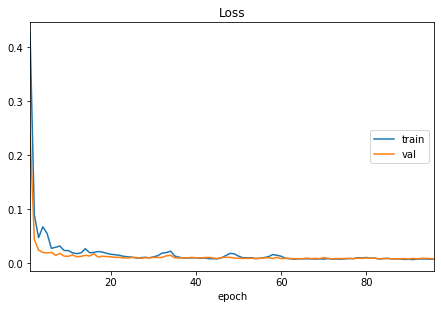

In [29]:
nEpochs = 96
batchSize = 64

tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=1)

history1 = model1.fit(xtrain, ytrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_split=0.1, 
            verbose=0,
            callbacks=[tvPlot]);

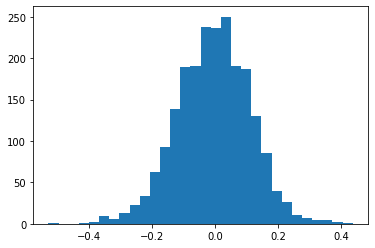

In [30]:
weights1 = model1.get_weights()
plt.hist(weights1[0].ravel(), bins=30);

### Evaluation du DNN

In [31]:
yEst = model1.predict(xtest)
yEst = scaleY.inverse_transform(yEst)

error @ 80% = 4406.1 m


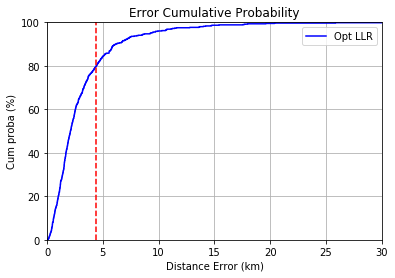

In [32]:
# The coordinates are in true X,Y for distance computation (UTM => directly in meters)
delta_y = yEst[:,0] - ytest[:,0]
delta_x = yEst[:,1] - ytest[:,1]

dnnErr_vec = np.sqrt(delta_x**2 + delta_y**2)

plotError(dnnErr_vec)

## DNN avec validation "leave out device K fold"

Utilisation de GroupKFold de Scikit Learn, génère K fold en évitant que les éléments d'un groupe se trouvent dans le train et le valid. K=24 est choisit pour avoir une distribution des performances (voir histogramme ci-dessous).

In [133]:
gkl1o = model_selection.GroupKFold(24) #model_selection.LeaveOneGroupOut()

In [34]:
scaleX = preprocessing.StandardScaler()
scaleX.fit(df_feat_red)
df_feat_scaled = scaleX.transform(df_feat_red)

scaleY = preprocessing.StandardScaler()
scaleY.fit(ground_truth[['y', 'x']])
yscaled = scaleY.transform(ground_truth[['y', 'x']]y)

In [35]:
nEpochs = 96

errors80Dnn = []
i = 0
for train, val in gkl1o.split(df_feat, groups=df_feat['did']):
    
    i+=1
    if i % 4 == 0: print('Split #', i)  
    
    xtrain = df_feat_scaled[train]
    xval = df_feat_scaled[val]
    ytrain = yscaled[train]
    yval = yscaled[val]
    
    model1.reset_states()
    model1.fit(xtrain, ytrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_data=(xval, yval),
            verbose=0)
    
    # Evaluate
    yEst = model1.predict(xval)
    yEst = scaleY.inverse_transform(yEst)
    
    delta_y = yEst[:,0] - ground_truth['y'][val]
    delta_x = yEst[:,1] - ground_truth['x'][val]
    
    # Estimates are in delta of UTM coordinates => meters
    dnnErr_vec = np.sqrt(delta_x**2 + delta_y**2)
    err80 = np.percentile(dnnErr_vec, 80)
    #print('Err @ 80%%, %.1fm' % (err80))
    errors80Dnn.append(err80) 

Split # 4
Split # 8
Split # 12
Split # 16
Split # 20
Split # 24


# Modèle de gradient boosting ( LightGBM) 

## LGBM avec validation "Leave out device K fold"

In [136]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 250,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

errors80Lgbm = []
lgbmModels = []
i = 0
for train, val in gkl1o.split(df_feat, groups=df_feat['did']):
    i+=1
    if i % 4 == 0:
        print('Split #', i)
    
    xtrain = df_feat_red.values[train]
    xval = df_feat_red.values[val]
    
    lat_train = lightgbm.Dataset(xtrain, ground_truth['y'][train])
    lat_valid = lightgbm.Dataset(xval, ground_truth['y'][val])
    model_lat = lightgbm.train(params,
                           lat_train,
                           valid_sets=lat_valid,
                           num_boost_round=5000,
                           early_stopping_rounds=250,verbose_eval=False) 

    lng_train = lightgbm.Dataset(xtrain, ground_truth['x'][train])
    lng_valid = lightgbm.Dataset(xval, ground_truth['x'][val])
    model_lng = lightgbm.train(params,
                           lng_train,
                           valid_sets=lng_valid,
                           num_boost_round=5000,
                           early_stopping_rounds=250,verbose_eval=False) 

    # Evaluate
    lat_pred = model_lat.predict(xval)
    lng_pred = model_lng.predict(xval)
    
    delta_y = lat_pred - ground_truth['y'][val]
    delta_x = lng_pred - ground_truth['x'][val]
    
    # Estimates are in delta of UTM coordinates => meters
    lgbmErr_vec = np.sqrt(delta_x**2 + delta_y**2)
    err80 = np.percentile(lgbmErr_vec, 80)
    errors80Lgbm.append(err80) 
    lgbmModels.append([model_lat, model_lng])

Split # 4
Split # 8
Split # 12
Split # 16
Split # 20
Split # 24


In [137]:
#lat_pred = model_lat.predict(xtest)
#lng_pred = model_lng.predict(xtest)
#
#lgbmErr_vec = eval_geoloc(ytest[:,0], ytest[:,1], lat_pred, lng_pred)
#plotError(lgbmErr_vec)

In [212]:
def lgbmPredict(models, X, degreeOutput):
    
    X_red = X.drop(['did', 'pivot_utm_zone',  'pivot_utm_letter'], axis=1)
    
    lat, lng = np.zeros(len(X_red)), np.zeros(len(X_red))
    for m in models:
        lat += m[0].predict(X_red)
        lng += m[1].predict(X_red)
    
    lat = lat / len(models)
    lng = lng / len(models)
    
    if degreeOutput:
        lat_out, lng_out = np.empty(len(lat)), np.empty(len(lng))
        for i, (y, x, uz, ul) in enumerate(zip(lat, lng, X['pivot_utm_zone'], X['pivot_utm_letter'])):
            a, b = xy_to_latlon(x, y, uz, ul)
            lat_out[i] = a
            lng_out[i] = b
        return lat_out, lng_out
    else:
        return lat, lng

## Graphique comparatif des modèles

Mean error over device folds @ 80%, DNN : 4686.5m, LGBM : 4572.6m


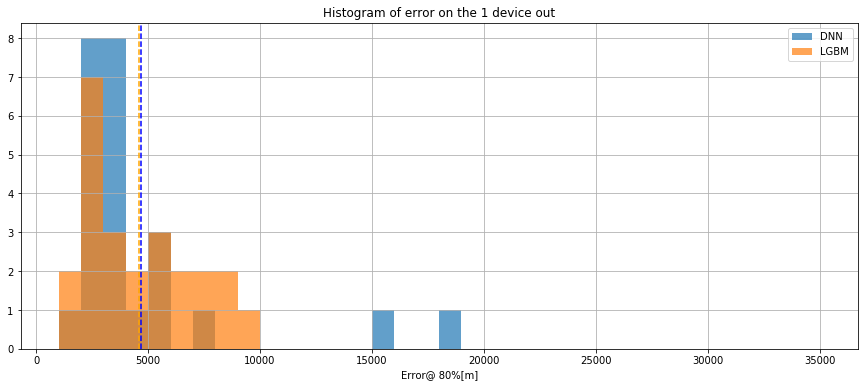

In [139]:
bins = np.arange(1, 36) * 1000
errorMeanOverDevicesDnn = np.array(errors80Dnn).mean()
errorMeanOverDevicesLgbm = np.array(errors80Lgbm).mean()
print('Mean error over device folds @ 80%%, DNN : %.1fm, LGBM : %.1fm' % \
          (errorMeanOverDevicesDnn, errorMeanOverDevicesLgbm))
fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(errors80Dnn,  bins=bins, alpha=0.7, label='DNN')
ax.hist(errors80Lgbm, bins=bins, alpha=0.7, label='LGBM')
ax.set_title('Histogram of error on the 1 device out')
ax.set_xlabel('Error@ 80%[m]')
ax.axvline(x=errorMeanOverDevicesDnn,  color='blue', linestyle='--')
ax.axvline(x=errorMeanOverDevicesLgbm, color='orange', linestyle='--')
ax.legend()
ax.grid()

## Etude d'un device anormal (outlier) 

Device ID=476835 a des performances très mauvaises (erreur @ 80% > 100km).

Cette section détermine les problèmes des messages de ce device

In [175]:
outlier1Did = 476835.
outlier1Index = df_mess_train['did'] == outlier1Did
outlier1X = df_mess_train[outlier1Index]
outlier1X.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,bs_x,bs_y,bs_utm_zone,bs_utm_letter
17074,57c4a76fe541cd77a07a17be,3558,476835.0,1.0,-91.666667,1.472506e+12,39.810055,-105.010413,499108.653441,4.406676e+06,13,S
17075,57c4a76fe541cd77a07a17be,4060,476835.0,1.0,-130.000000,1.472506e+12,39.798157,-104.915073,507270.638137,4.405358e+06,13,S
17076,57c4a76fe541cd77a07a17be,8475,476835.0,1.0,-124.000000,1.472506e+12,39.811782,-105.026329,497746.413704,4.406868e+06,13,S
17086,57c4aa0612f14345918d26f0,1661,476835.0,1.0,-135.000000,1.472506e+12,39.753850,-105.018596,498406.965168,4.400438e+06,13,S
17087,57c4aa0612f14345918d26f0,1859,476835.0,1.0,-129.000000,1.472506e+12,39.704887,-105.016392,498594.756068,4.395004e+06,13,S


In [176]:
outlier1MessId = df_mess_train[outlier1Index].reset_index()['messid'].unique()
outlier1MessId.shape

(69,)

In [178]:
df_feat_rank1OutlierIndex = (df_feat['did'] == outlier1Did)
df_feat_red[df_feat_rank1OutlierIndex].head()

,,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi
messid,,,,,,,,,,,,,,,,,,
57c4a76fe541cd77a07a17be,0,4.406676e+06,499108.653441,3.725290e-09,-5.820766e-11,-91.666667,192.003026,-1362.239737,-124.0,-1317.076119,8161.984696,-130.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
57c4aa0612f14345918d26f0,0,4.400730e+06,498408.673777,-2.921655e+02,-1.708609e+00,-108.000000,-292.165534,-1.708609,-109.0,4117.899997,28.776417,-110.333333,4576.830986,-3565.348787,-117.333333,2684.407061,-3005.090229,-118.0
57c4aca6cf554f465a3baffd,0,4.403426e+06,493999.999985,1.508099e+02,-2.253998e+02,-112.000000,-2988.336102,4406.965182,-115.0,-2634.864537,8045.016346,-119.333333,-983.462053,5193.590776,-120.000000,4539.043930,4019.092181,-123.0
57c69d31e541cd77a0d00095,0,4.403414e+06,495403.583546,-4.034489e-06,1.366949e-06,-87.000000,1892.423922,-560.258557,-107.0,88.848316,1105.795196,-109.666667,285.668446,-3002.883958,-110.000000,2568.978638,-1574.739607,-111.0
57c69f7fcf554f465a9067a7,0,4.406162e+06,496495.278297,-9.313226e-10,-1.164153e-10,-125.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0


In [179]:
outlier1y = ground_truth[df_feat_rank1OutlierIndex.values]
outlier1y.head()

,x,y,utm_zone,utm_letter
messid,,,,
57c4a76fe541cd77a07a17be,499943.884136,4.406363e+06,13,S
57c4aa0612f14345918d26f0,499566.265716,4.404406e+06,13,S
57c4aca6cf554f465a3baffd,499279.462179,4.405150e+06,13,S
57c69d31e541cd77a0d00095,495787.977617,4.403556e+06,13,S
57c69f7fcf554f465a9067a7,495759.856805,4.403579e+06,13,S


Utilisation du dernier estimateur LGBM

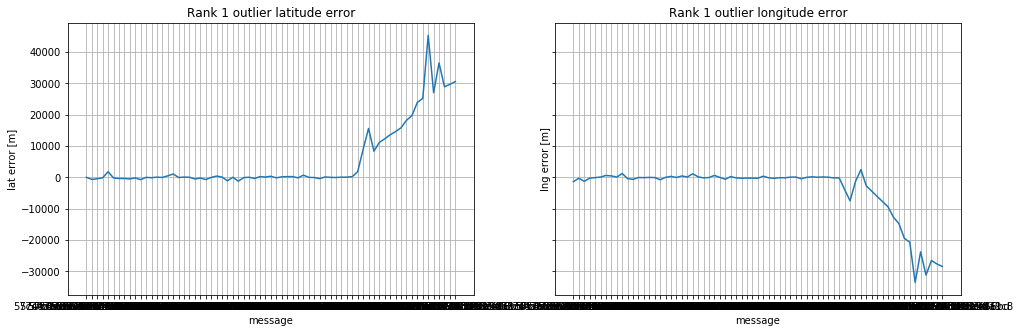

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
error_lat = model_lat.predict(df_feat_red.loc[outlier1MessId]) - outlier1y['y']
axes[0].plot(error_lat)
axes[0].set_title('Rank 1 outlier latitude error')
axes[0].set_xlabel('message')
axes[0].set_ylabel('lat error [m]')
axes[0].grid()
error_lng = model_lng.predict(df_feat_red.loc[outlier1MessId]) - outlier1y['x']
axes[1].plot(error_lng)
axes[1].set_title('Rank 1 outlier longitude error')
axes[1].set_xlabel('message')
axes[1].set_ylabel('lng error [m]')
axes[1].grid()

In [ ]:
df_feat_red.loc[outlier1MessId][50:]

Les 17 derniers messages n'ont qu'une seule BS et le device s'éloigne de la BS.

Ils sont affichés en bleu sur la carte suivante, au sud de Denver. Les BS, de tous les messages de ce device, sont en rouge.

In [202]:
m = folium.Map(
    location=[39.8, -105.0],
    zoom_start=6,
    tiles='Stamen Terrain'
)

for r in outlier1X.iterrows():
    row = r[1]
    folium.Circle(
        radius=max(5, 200+row['rssi']),
        location=[row['bs_lat'], row['bs_lng']],
        color='crimson',
        fill=False,
    ).add_to(m)
 
for r in outlier1y[52:].iterrows():
    row = r[1]
    lat,lng = xy_to_latlon(row[0], row[1], row[2], row[3])
    folium.Circle(
        radius=10,
        location=[lat, lng],
        color='blue',
        fill=False,
    ).add_to(m)

m

## Construction des vecteurs lat/lng de prédictions de test

Les labels ne sont pas connus.

In [183]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,bs_x,bs_y,bs_utm_zone,bs_utm_letter
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032,486028.742773,4.397654e+06,13,S
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479,494649.699245,4.403332e+06,13,S
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676,495403.583548,4.403414e+06,13,S
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032,486028.742773,4.397654e+06,13,S
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747,492400.699589,4.403700e+06,13,S


In [213]:
df_feat_test = feat_mat_const(df_mess_test, listOfBs)
df_feat.shape, df_feat_test.shape

((6068, 20), (5294, 20))

In [214]:
y_pred_test_lat, y_pred_test_lng = lgbmPredict(lgbmModels, df_feat_test, True)

In [219]:
test_res = pd.DataFrame(np.c_[y_pred_test_lat, y_pred_test_lng], columns = ['lat', 'lng'])
test_res = pd.concat([test_res, df_mess_test['messid']], axis=1)

In [220]:
test_res.head()

,lat,lng,messid
0,39.749487,-105.084818,573be2503e952e191262c351
1,39.781445,-105.075131,573c05f83e952e1912758013
2,39.704108,-105.011244,573c05f83e952e1912758013
3,39.788947,-105.076413,573c05f83e952e1912758013
4,39.701781,-105.009086,573c05f83e952e1912758013


In [221]:
df_feat_test.head()

,,did,pivot_lat,pivot_lng,pivot_utm_zone,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi,pivot_utm_letter
messid,,,,,,,,,,,,,,,,,,,,,
573be2503e952e191262c351,0,116539.0,4.397654e+06,486028.742773,13.0,-3.725290e-09,2.328306e-10,-111.0,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,S
573c05f83e952e1912758013,0,472504.0,4.403700e+06,492400.708017,13.0,7.581469e-04,-8.428478e-03,-105.0,-123.094306,1373.892202,-117.000000,-285.667691,3002.875530,-127.0,-5415.770732,-6569.904885,-127.0,-6046.385115,-6371.965244,-129.0,S
573c0796f0fe6e735a66deb3,0,472397.0,4.389433e+06,496252.495863,13.0,-5.322439e-01,-1.742543e-01,-119.5,5570.647711,2342.260205,-129.000000,4249.521041,-56.922901,-130.0,-4655.741801,2989.831147,-134.5,0.000000,0.000000,-1000.0,S
573c08d2864fce1a9a0563bc,0,472504.0,4.403577e+06,493774.600220,13.0,-3.725290e-09,-3.492460e-10,-113.0,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,S
573c08ff864fce1a9a0579b0,0,472397.0,4.389433e+06,496252.533406,13.0,-5.987064e-01,-2.117975e-01,-121.0,5570.581248,2342.222661,-130.333333,4249.454578,-56.960444,-131.5,-4655.808264,2989.793604,-134.0,0.000000,0.000000,-1000.0,S


In [222]:
test_res.to_csv('pred_pos_test_list.csv', index=False)